Imports and constants assignation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.config.list_physical_devices('GPU')

2023-05-22 09:50:43.029119: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-22 09:50:43.030465: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 09:50:43.056347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 09:50:43.056922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 09:50:43.493977: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

[]

In [2]:

### Constants
samples_per_record = 3327
fs = 16000
inputs = []
outputs = []
flag = True

# List of commands that the nn will recognize
# commands = ['now', 'take','fetch','noise','cancel','driver','pillow','slider','stick','stop','wrench','piston','crank']

# commands = ['noise','go', 'take','bring','cancel','one','two','three','four','five','six','seven']
commands = ['noise','cancel','one','two','three','four','five','six','seven']
commands = ['noise', 'go']
commands = ['noise', 'take','bring','go','cancel']
# commands = ['five','six','seven','noise']
num_commands = len(commands)

# create a one-hot encoded matrix that is used in the output
encoded_commands = np.eye(num_commands)

# Definir los parámetros para el espectrograma
win = np.hamming(1024)
nfft = 1024
hop = nfft // 2


Data parse

In [3]:

# read each csv file and push an input and output
for command_idx in range(num_commands):
  command = commands[command_idx]
  print(f"Processing index {command_idx} for command '{command}'.")
  
  output = encoded_commands[command_idx]
  
  df = np.loadtxt("data_set/" + command + ".txt")
  
  # calculate the number of command recordings in the file
  num_recordings = int(df.shape[0] / samples_per_record)
  
  print(f"\tThere are {num_recordings} recordings of the {command} command.")
  
  for i in range(num_recordings):
    tensor = []
    start = i*samples_per_record
    end = start+samples_per_record
    spec, freqs, times, _ = plt.specgram(df[start:end], NFFT=nfft, Fs=fs, window=win, noverlap=hop, mode='magnitude')
    plt.close()
    tensor = spec

    inputs.append(tensor)
    outputs.append(output)
  # print('\tSorting ',command)
  
  # convert the list to numpy array
  inputs = np.array(inputs)
  outputs = np.array(outputs)

  if flag:
      inputs_train = np.empty((0,inputs.shape[1],inputs.shape[2]))
      inputs_test = np.empty((0,513,5))
      inputs_validate = np.empty((0,513,5))
      outputs_train = np.empty((0,outputs.shape[1]))
      outputs_test = np.empty((0,outputs.shape[1]))
      outputs_validate = np.empty((0,outputs.shape[1]))
      temp_inputs_train = np.empty((0,513,5))
      temp_inputs_test = np.empty((0,513,5))
      temp_inputs_validate = np.empty((0,513,5))
      temp_outputs_train = np.empty((0,outputs.shape[1]))
      temp_outputs_test = np.empty((0,outputs.shape[1]))
      temp_outputs_validate = np.empty((0,outputs.shape[1]))
      flag = False

  # Sort inputs randomly
  num_inputs = len(inputs)
  random_idx = np.arange(num_inputs)
  np.random.shuffle(random_idx)

  inputs = inputs[random_idx]
  outputs = outputs[random_idx]

  # Split the inputs into: training (60%), testing(20%) and validation(20%)
  train_idx = int(0.8 * num_inputs)
  test_idx = int(0.1 * num_inputs + train_idx)

  temp_inputs_train, temp_inputs_test, temp_inputs_validate = np.split(inputs, [train_idx, test_idx])
  temp_outputs_train, temp_outputs_test, temp_outputs_validate = np.split(outputs, [train_idx, test_idx])
  
  
  inputs_train = np.vstack([inputs_train, temp_inputs_train])
  inputs_test = np.vstack([inputs_test, temp_inputs_test])
  inputs_validate = np.vstack([inputs_validate, temp_inputs_validate])
  # print('Inputs train shape: ',inputs_train.shape)

  outputs_train = np.vstack([outputs_train, temp_outputs_train])
  outputs_test = np.vstack([outputs_test, temp_outputs_test])
  outputs_validate = np.vstack([outputs_validate, temp_outputs_validate])

  inputs = []
  outputs = [] 

print("Data set parsing and preparation complete.")

Processing index 0 for command 'noise'.
	There are 105 recordings of the noise command.
Processing index 1 for command 'take'.
	There are 430 recordings of the take command.
Processing index 2 for command 'bring'.
	There are 303 recordings of the bring command.
Processing index 3 for command 'go'.
	There are 355 recordings of the go command.
Processing index 4 for command 'cancel'.
	There are 311 recordings of the cancel command.
Data set parsing and preparation complete.


Randomize samples

In [4]:

num_inputs = len(inputs_train)
random_idx = np.arange(num_inputs)
np.random.shuffle(random_idx)

inputs_train = inputs_train[random_idx]
outputs_train = outputs_train[random_idx]

# Ajustar la forma de los datos de entrada
inputs_train = np.expand_dims(inputs_train, axis=1)
inputs_validate = np.expand_dims(inputs_validate, axis=1)
inputs_test = np.expand_dims(inputs_test, axis=1)

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


Model training and bulding

In [5]:
# # build the model and train it

# # Define the input shape
# input_shape = inputs_train[1].shape

# # Define the number of filters and filter sizes for the first layer
# filters_layer_1 = 32
# filter_size_layer_1 = (5,5)
# model = 0
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Conv2D(filters=filters_layer_1, padding='same', kernel_size=filter_size_layer_1,activation='relu', input_shape=input_shape))
# model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*2, padding='same', kernel_size=filter_size_layer_1,activation='relu'))
# model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*4, padding='same', kernel_size=filter_size_layer_1,activation='relu'))
# model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*8, padding='same', kernel_size=filter_size_layer_1,activation='relu'))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dense(num_commands, activation='softmax'))
# # model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
# # optimizer= adam loss= crossentropy metrics = accuracy
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=10, validation_data=(inputs_validate, outputs_validate), callbacks=[early_stop])

# # history = model.fit(inputs_train, outputs_train, epochs=30, batch_size=10, validation_data=(inputs_validate, outputs_validate))

In [6]:
from tensorflow.keras import regularizers
# build the model and train it

# Define the input shape
input_shape = (inputs_train[1].shape)

# Define the number of filters and filter sizes for the first layer
filters_layer_1 = 32
filter_size_layer_1 = (5,5)
filter_size_layer_2 = (3,3)

model = 0
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=filters_layer_1, padding='same', kernel_size=filter_size_layer_2,
                                activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))

model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*2, padding='same', kernel_size=filter_size_layer_2,
                                activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))

model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*4, padding='same', kernel_size=filter_size_layer_2,
                                activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))

model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*4, padding='same', kernel_size=filter_size_layer_2,
                                activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(num_commands, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 513, 32)        1472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 256, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 256, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 128, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 128, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 64, 128)       0

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=4,
                    validation_data=(inputs_validate, outputs_validate),
                    callbacks=[early_stopping])

Epoch 1/100
301/301 [==============================] - 2s 5ms/step - loss: 1.0335 - accuracy: 0.6606 - val_loss: 0.4871 - val_accuracy: 0.8627
Epoch 2/100
301/301 [==============================] - 1s 4ms/step - loss: 0.6146 - accuracy: 0.8053 - val_loss: 0.3540 - val_accuracy: 0.9150
Epoch 3/100
301/301 [==============================] - 1s 5ms/step - loss: 0.5301 - accuracy: 0.8319 - val_loss: 0.3505 - val_accuracy: 0.9150
Epoch 4/100
301/301 [==============================] - 1s 5ms/step - loss: 0.4934 - accuracy: 0.8469 - val_loss: 0.3361 - val_accuracy: 0.9281
Epoch 5/100
301/301 [==============================] - 1s 5ms/step - loss: 0.4684 - accuracy: 0.8744 - val_loss: 0.3244 - val_accuracy: 0.9281
Epoch 6/100
301/301 [==============================] - 1s 5ms/step - loss: 0.4044 - accuracy: 0.9043 - val_loss: 0.2988 - val_accuracy: 0.9346
Epoch 7/100
301/301 [==============================] - 1s 5ms/step - loss: 0.3877 - accuracy: 0.9027 - val_loss: 0.3025 - val_accuracy: 0.9281

Loss graph

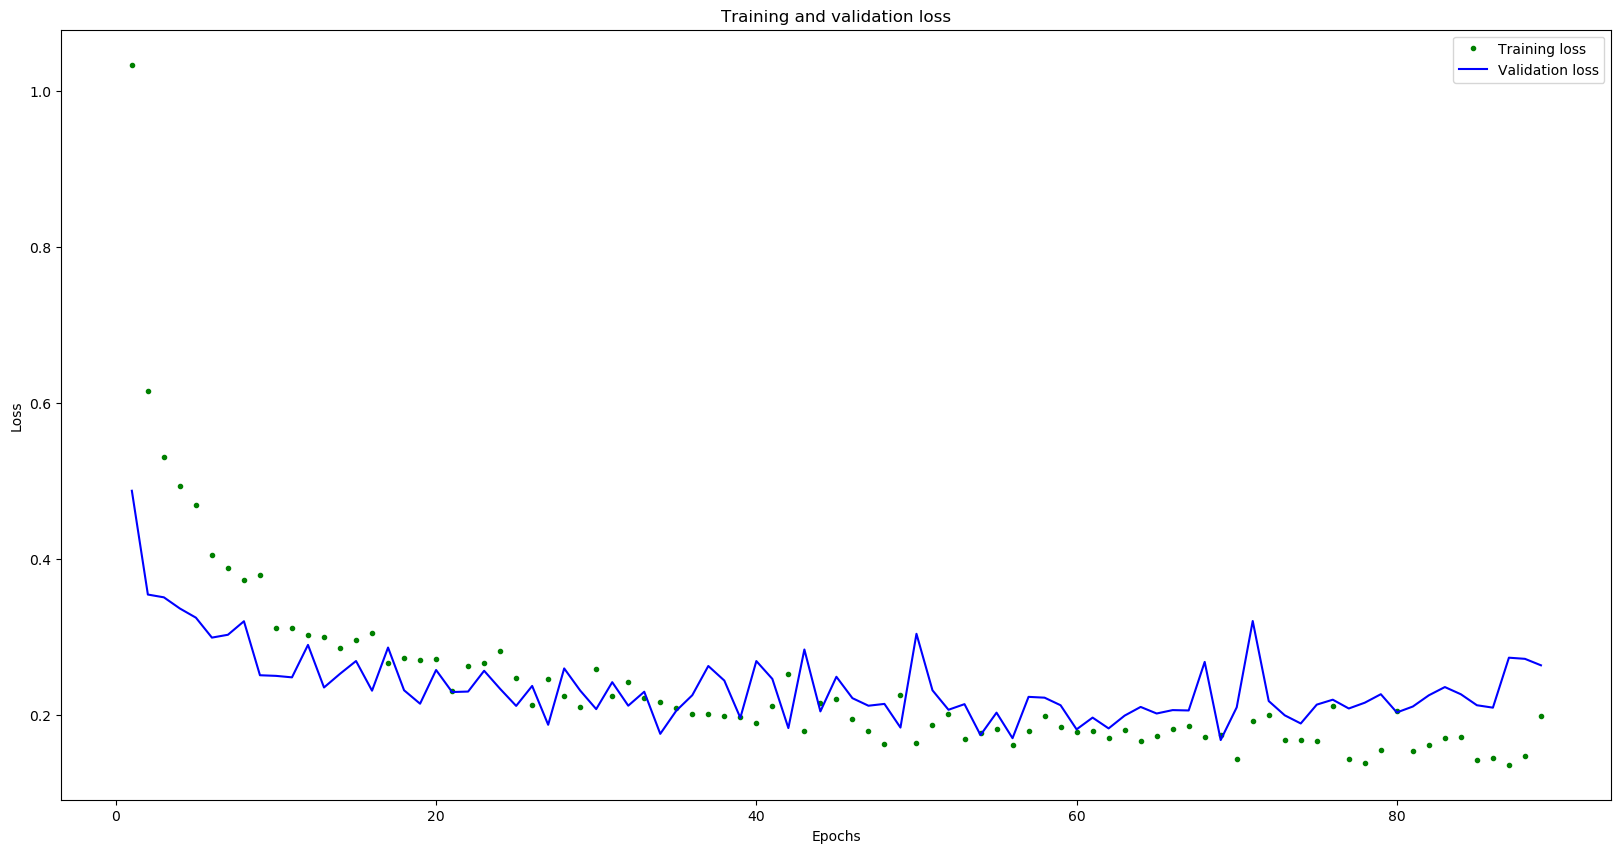

In [8]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


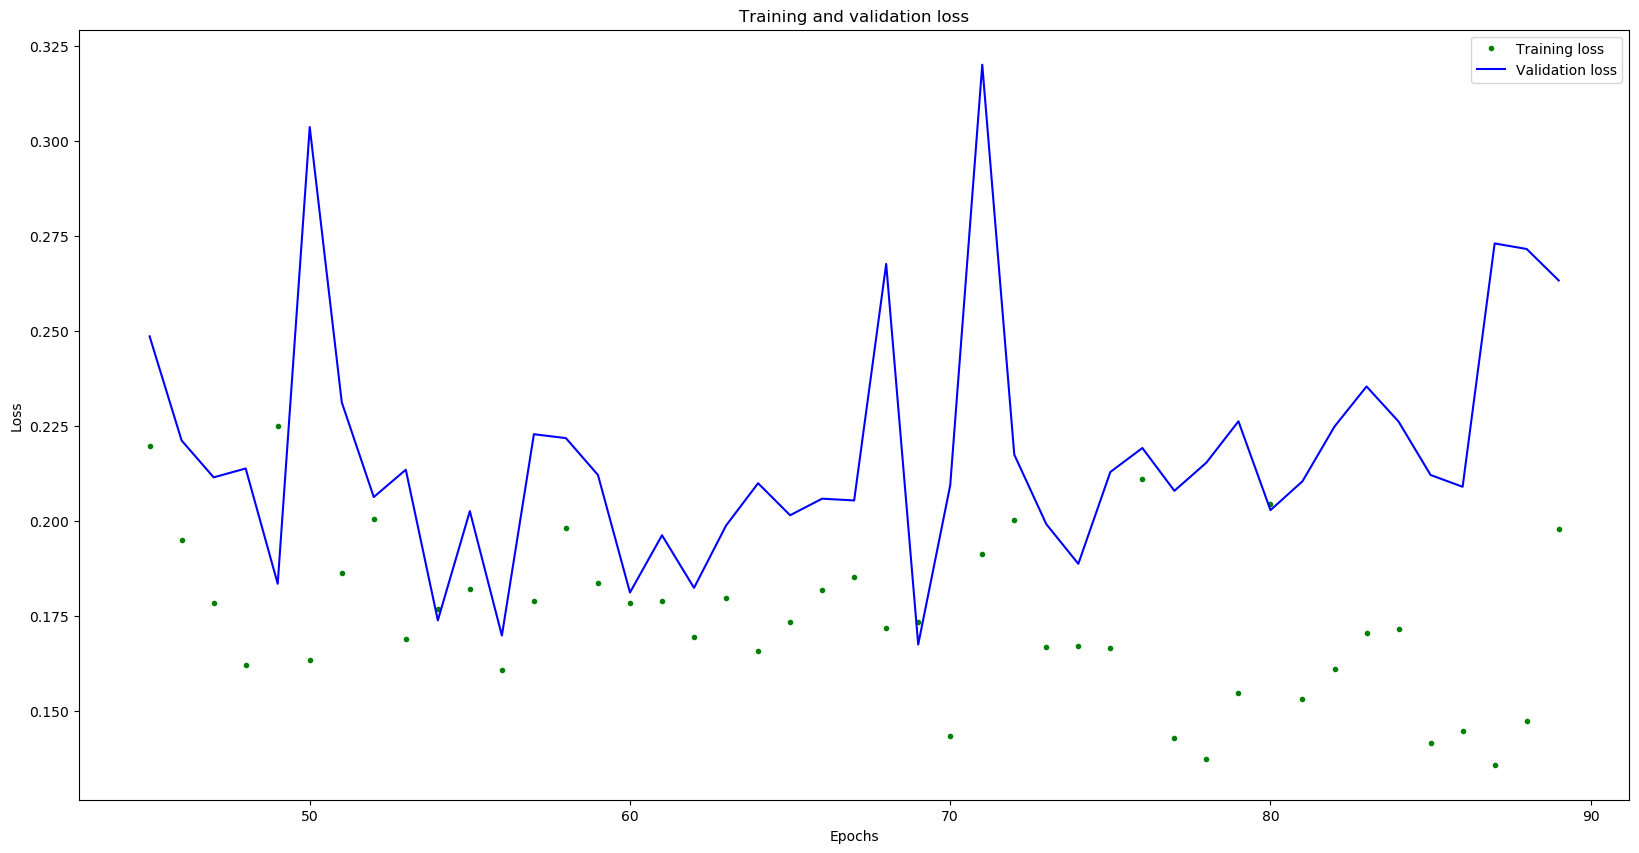

In [9]:
# graph the loss again skipping a bit of the start
SKIP = int(len(epochs)/2)
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy graph

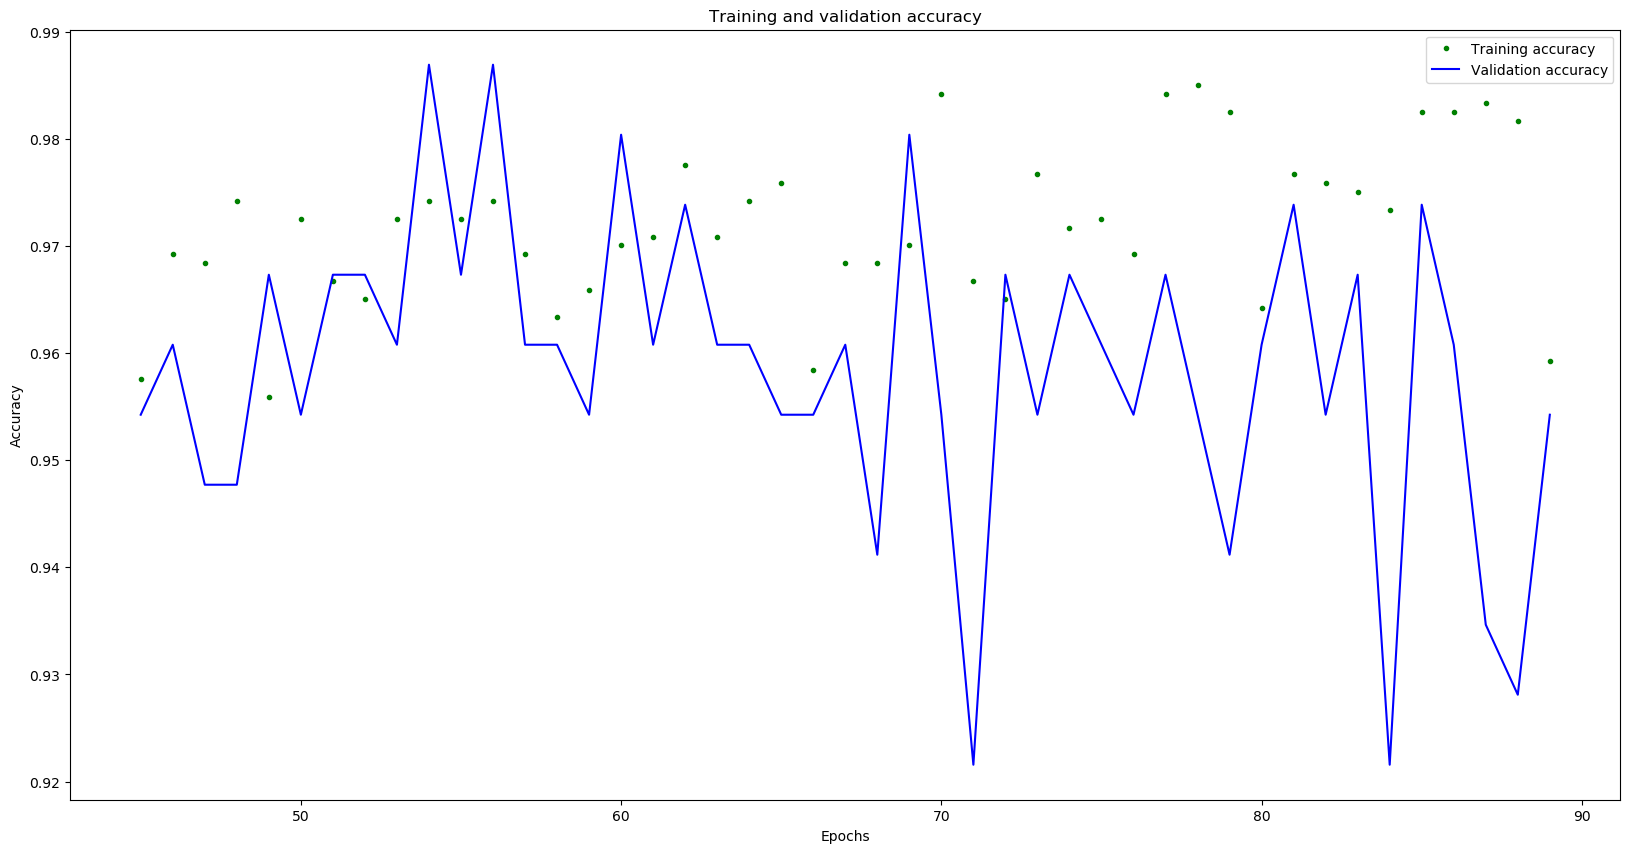

In [11]:
# graph of accuracy
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training accuracy')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Test model predictions

5/5 [==============================] - 0s 4ms/step
class: 5


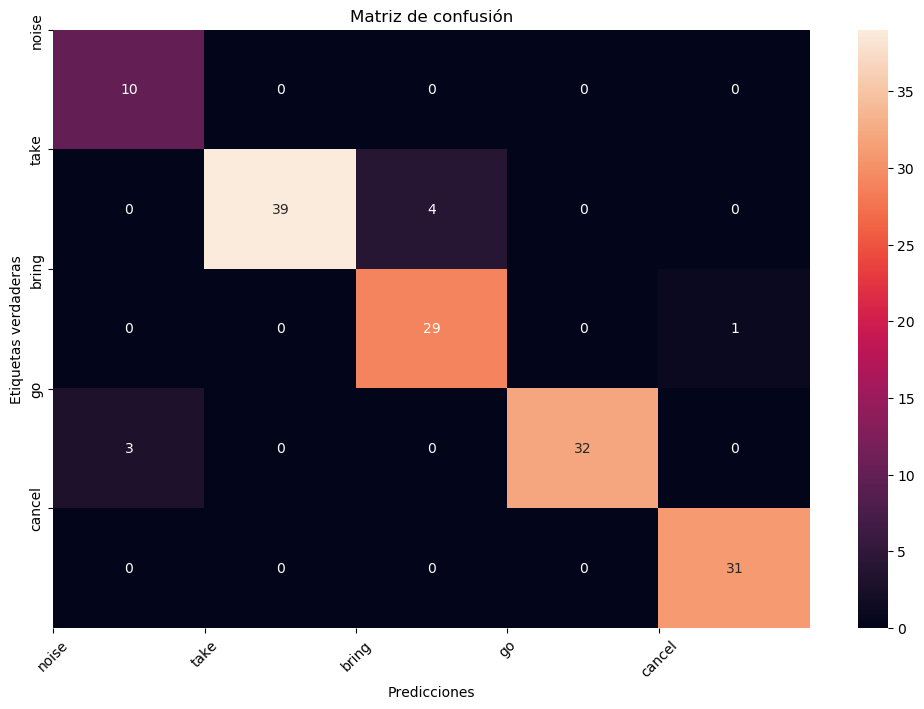

Accuracy: 0.9463087248322147


In [12]:
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
# use the model to predict the test inputs
# inputs_test = np.expand_dims(inputs_test, axis=1)
predictions = model.predict(inputs_test)

# Calcula la matriz de confusión utilizando NumPy
num_classes = len((outputs_test[1]))
print('class:',num_classes)
confusion_matrix = np.zeros((num_classes, num_classes))

for i in range(len(outputs_test)):
    true_class = np.argmax(outputs_test[i])
    predicted_class = np.argmax(predictions[i])
    confusion_matrix[true_class][predicted_class] += 1
# print(confusion_matrix)

# Imprime la matriz de confusión utilizando la biblioteca matplotlib.pyplot
# plt.imshow(confusion_matrix, cmap=plt.cm.Blues, annot=True)
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix, annot=True)
plt.title("Matriz de confusión")
# plt.colorbar()
tick_marks = np.arange(len(commands))
plt.xticks(tick_marks, commands, rotation=45)
plt.yticks(tick_marks, commands)
plt.tight_layout()
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()

## Accuracy

total_correct = 0
for i in range(num_classes):
    total_correct += confusion_matrix[i][i]

total = np.sum(confusion_matrix)
accuracy = total_correct / total

print('Accuracy:', accuracy)


Convert model to tensorflow lite

In [14]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("go.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("command_model_new.tflite")
print("Model is %d bytes" % basic_model_size)

2023-05-22 09:57:15.657156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-22 09:57:15.821715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /tmp/tmp25j7xvzn/assets


INFO:tensorflow:Assets written to: /tmp/tmp25j7xvzn/assets
2023-05-22 09:57:16.547382: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-22 09:57:16.547402: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-22 09:57:16.547527: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp25j7xvzn
2023-05-22 09:57:16.549274: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-22 09:57:16.549287: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp25j7xvzn
2023-05-22 09:57:16.554441: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-22 09:57:16.595777: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp25j7xvzn
2023-05-22 09:57:16.605835: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

FileNotFoundError: [Errno 2] No such file or directory: 'command_model_new.tflite'